# Import Libraries

In [33]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
from time import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import feature_selection
from sklearn.feature_selection import (
    RFE,
    SelectFromModel
)
from sklearn import linear_model
from sklearn.linear_model import (
    LogisticRegression,
    LassoCV
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.decomposition import PCA
import featuretools as ft
from autofeat import AutoFeatClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,
    classification_report,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    fbeta_score
)
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder, 
    LabelEncoder
)
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge


# Import Dataset

In [36]:
df = pd.read_csv('/Users/kritikanayyar/Documents/MMA/3 & 4. Complementary Courses Selection/7. Enterprise Data Science & Machine Learning in Production II/targeted_marketing/Dataset/bank-full.csv', delimiter=';')
#convert target variable to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


In [37]:
df = df.drop(['contact','poutcome'], axis=1)

In [38]:
# convert binary variables to 0 and 1
df['default'] = df['default'].map({'yes': 1, 'no': 0}).astype(int)
df['housing'] = df['housing'].map({'yes': 1, 'no': 0}).astype(int)
df['loan'] = df['loan'].map({'yes': 1, 'no': 0}).astype(int)

#dummify multi-class categorical variables
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'month'])
df

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,0,2143,1,0,5,261,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
1,44,0,29,1,0,5,151,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
2,33,0,2,1,1,5,76,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
3,47,0,1506,1,0,5,92,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
4,33,0,1,0,0,5,198,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,False,False,False,False,False,False,False,True,False,False
45207,71,0,1729,0,0,17,456,2,-1,0,...,False,False,False,False,False,False,False,True,False,False
45208,72,0,5715,0,0,17,1127,5,184,3,...,False,False,False,False,False,False,False,True,False,False
45209,57,0,668,0,0,17,508,4,-1,0,...,False,False,False,False,False,False,False,True,False,False


In [39]:
df = df.drop(['duration'], axis=1)

In [40]:
#split data into training and testing
from sklearn.model_selection import train_test_split
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

Percentage of the target variable:
y
0    90.389709
1     9.610291
Name: proportion, dtype: float64


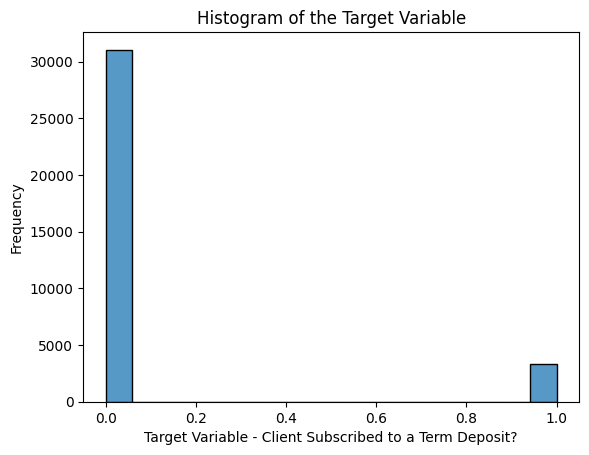

In [42]:
#plot the histogram of the target variable
plt.xlabel('Target Variable - Client Subscribed to a Term Deposit?')
plt.ylabel('Frequency')
plt.title('Histogram of the Target Variable')
sns.histplot(training_data['y'])
print("Percentage of the target variable:")
print(training_data['y'].value_counts(normalize=True) * 100)

In [43]:
from imblearn.over_sampling import RandomOverSampler

df_copy = training_data.copy()
X = df_copy.drop('y', axis=1)
y = df_copy['y']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
df_copy = pd.concat([X_resampled, y_resampled], axis=1)
print(df_copy['y'].value_counts())
df_copy

y
0    31057
1    31057
Name: count, dtype: int64


,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin.,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,41,0,849,1,0,15,1,-1,0,False,...,False,False,False,False,False,True,False,False,False,0
1,49,0,1415,1,0,30,2,-1,0,False,...,False,False,True,False,False,False,False,False,False,0
2,42,0,3842,0,0,31,4,-1,0,True,...,False,False,True,False,False,False,False,False,False,0
3,37,0,-119,1,0,11,11,-1,0,False,...,False,False,False,True,False,False,False,False,False,0
4,56,0,3498,0,0,15,2,-1,0,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62109,32,0,2465,0,0,13,1,-1,0,False,...,False,False,False,False,False,False,False,False,False,1
62110,54,0,377,0,0,8,1,-1,0,False,...,False,False,False,False,False,False,False,False,False,1
62111,33,0,3552,0,0,13,2,85,3,False,...,True,False,False,False,False,False,False,False,False,1
62112,28,0,844,0,0,16,2,-1,0,False,...,False,False,False,False,False,False,False,False,False,1


In [44]:
#standardize the data using minmax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = df_copy.drop(['y'], axis=1)
y = df_copy['y']
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df_copy.drop(['y'], axis=1).columns)
Xt = scaler.transform(X_test)
Xt = pd.DataFrame(Xt, columns=X.columns)

In [45]:
X_train = df_copy.drop('y', axis=1)
y_train = df_copy['y']

X_test = X_test.copy()
y_test = y_test.copy()

In [46]:
X_train_std = X
y_train_std = y_train.copy()

X_test_std = Xt
y_test_std = y_test.copy()

In [47]:
# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier()

# Fit the model on the non-scaled training data
gb.fit(X_train, y_train)

# Predict on the non-scaled test data
y_pred_gb = gb.predict(X_test)

# Calculate accuracy, precision, recall, F1 score, and ROC-AUC
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1 Score": f1_score(y_test, y_pred_gb),
    "ROC AUC": roc_auc_score(y_test, y_pred_gb),
}

In [56]:
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.3f}")

metrics_df

,Metric,Value
0,Accuracy,0.762
1,Precision,0.281
2,Recall,0.624
3,F1 Score,0.388
4,ROC AUC,0.703


# Data Drift
Data Drift is a change in the distribution of data used in a prediction model.

- Feature Drift (or Covariate Drift): It happens when some previously infrequent or even unseen features become more frequent, and vice versa. However, the relationship between the feature and the target is still the same.
- Data Drift:
- Concept Drift:
- Dual Drift & Multi Drift:
- Prediction Drift:
- Target Drift:

## Statistical techniques

### Kullback-Leibler (KL) Divergence
KL Divergence is a measure of how one probability distribution is different from a second, reference probability distribution.

In [54]:
# Function to calculate KL Divergence for all features
def calculate_kl_divergence(X_train, X_test, n_bins=10):
    kl_divergences = {}
    for feature in X_train.columns:
        # Creating histograms
        train_hist, bin_edges = np.histogram(X_train[feature], bins=n_bins, density=True)
        test_hist, _ = np.histogram(X_test[feature], bins=bin_edges, density=True)

        # Adding small constant to avoid division by zero
        train_hist += 1e-10
        test_hist += 1e-10

        # Normalize histograms to get probability distributions
        train_hist /= train_hist.sum()
        test_hist /= test_hist.sum()

        # Calculate KL Divergence (using scipy entropy function)
        kl_div = entropy(test_hist, train_hist)
        kl_divergences[feature] = kl_div

    return kl_divergences

In [49]:
from scipy.stats import entropy
# Calculating KL Divergence for each feature
kl_divergences = calculate_kl_divergence(X_train_std, X_test_std)

KL Divergence per feature: {'age': 0.006553239179562437, 'default': 0.0009581813316202076, 'balance': 0.0017691208927729898, 'housing': 0.01011842806700046, 'loan': 0.006571612299257047, 'day': 0.0028636818510297778, 'campaign': 0.0031843916619846264, 'pdays': 0.014907267219555563, 'previous': 0.007746960167444734, 'job_admin.': 5.482053562977634e-06, 'job_blue-collar': 0.0015801128280204003, 'job_entrepreneur': 0.000746087045267076, 'job_housemaid': 0.0008578547828128535, 'job_management': 0.0013339573204927263, 'job_retired': 0.0008768495752253091, 'job_self-employed': 4.531412151616678e-05, 'job_services': 7.678781111474745e-05, 'job_student': 3.1232337633178755e-05, 'job_technician': 0.00021664893703892633, 'job_unemployed': 9.993719029423222e-05, 'job_unknown': 1.6787782328201936e-06, 'marital_divorced': 0.003128558282738704, 'marital_married': 3.072632404505513e-07, 'marital_single': 0.001401593618479871, 'education_primary': 0.005046732023049769, 'education_secondary': 0.0004322

In [55]:
# Formatting KL Divergence values for better readability
kl_df = pd.DataFrame(list(kl_divergences.items()), columns=['Feature', 'KL Divergence'])
kl_df['KL Divergence'] = kl_df['KL Divergence'].apply(lambda x: f"{x:.3f}")

kl_df

,Feature,KL Divergence
0,age,0.007
1,default,0.001
2,balance,0.002
3,housing,0.010
4,loan,0.007
5,day,0.003
6,campaign,0.003
7,pdays,0.015
8,previous,0.008
9,job_admin.,0.000


In [57]:
# Categorize features based on KL Divergence values
low_kl_features = [feature for feature, divergence in kl_divergences.items() if divergence < 0.1]
moderate_kl_features = [feature for feature, divergence in kl_divergences.items() if 0.1 <= divergence < 0.5]
high_kl_features = [feature for feature, divergence in kl_divergences.items() if divergence >= 0.5]

# Display categorized lists
print("Low KL Divergence Features:", low_kl_features)
print("Moderate KL Divergence Features:", moderate_kl_features)
print("High KL Divergence Features:", high_kl_features)

Low KL Divergence Features: ['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']
Moderate KL Divergence Features: []
High KL Divergence Features: []


<div style="background-color: yellow; color: black; padding: 10px;">
    Result: All the features in our dataset have low KL Divergence values, which generally means that there is minimal drift between the probability distributions of these features in our training and test datasets. 
</div>

### Jensen-Shannon (JS) Divergence
JS Divergence is a method of measuring the similarity between two probability distributions. It is based on the KL divergence, with some notable differences, including that it is symmetric and it always has a finite value.

In [63]:
from scipy.spatial.distance import jensenshannon

# Function to calculate JS Divergence for all features
def calculate_js_divergence(X_train, X_test, n_bins=10):
    js_divergences = {}
    for feature in X_train.columns:
        # Creating histograms
        train_hist, bin_edges = np.histogram(X_train[feature], bins=n_bins, range=(0,1), density=True)
        test_hist, _ = np.histogram(X_test[feature], bins=bin_edges, density=True)

        # Calculate JS Divergence (using scipy jensenshannon function)
        js_div = jensenshannon(train_hist, test_hist, base=2)
        js_divergences[feature] = js_div

    return js_divergences

In [64]:
js_divergences = calculate_js_divergence(pd.DataFrame(X_train_std, columns=X_train.columns), pd.DataFrame(X_test_std, columns=X_test.columns))

# Create DataFrame from JS divergence results
js_df = pd.DataFrame(list(js_divergences.items()), columns=['Feature', 'JS Divergence'])

# Define thresholds for categorization
thresholds = {
    'Very Low Divergence': (0, 0.05),
    'Low to Moderate Divergence': (0.05, 0.20),
    'Moderate to High Divergence': (0.20, 0.50),
    'High Divergence': (0.50, 1)
}

# Categorizing features based on JS Divergence
divergence_categories = {k: [] for k in thresholds.keys()}
for index, row in js_df.iterrows():
    for category, (low, high) in thresholds.items():
        if low <= row['JS Divergence'] < high:
            divergence_categories[category].append(row['Feature'])

# Print categorized lists of features
for category, features in divergence_categories.items():
    print(f"{category} Features: {features}")

Very Low Divergence Features: ['age', 'default', 'balance', 'loan', 'day', 'campaign', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_sep']
Low to Moderate Divergence Features: ['housing', 'pdays', 'month_oct']
Moderate to High Divergence Features: []
High Divergence Features: []


<div style="background-color: yellow; color: black; padding: 10px;">
    Result: Features like housing, pdays, and month_oct are showing more noticeable changes in their distributions. These are still generally in the low range.
</div>

### Kolmogorov-Smirnov (KS) Test
KS Test is a nonparametric test of the equality of continuous (or discontinuous), one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test).

In [85]:
from alibi_detect.cd import KSDrift

# Initialize KSDrift detector
# Note: Check the exact syntax for the version of alibi-detect you are using, as API changes may occur.
cd = KSDrift(
    p_val=0.05,
    x_ref=X_train.values,  # Reference data, use numpy array format
    preprocess_x_ref=True,
    alternative='two-sided',  # Check for any kind of drift (two-sided)
    correction='bonferroni'  # Apply Bonferroni correction for multiple tests
)

# Predict drift on the test data
preds_drift = cd.predict(X_test.values, drift_type='batch', return_p_val=True, return_distance=True)

preds_drift

{'data': {'is_drift': 1,
  'distance': array([0.02722983, 0.00476359, 0.04458473, 0.07108458, 0.03849458,
         0.01378502, 0.03675222, 0.02855888, 0.02801181, 0.0010509 ,
         0.02239736, 0.00655955, 0.00609782, 0.0217666 , 0.00962644,
         0.00171394, 0.00348497, 0.00117087, 0.00784081, 0.00238669,
         0.00014136, 0.02388089, 0.00038436, 0.02426524, 0.0336883 ,
         0.01469682, 0.02674993, 0.00775845, 0.01714882, 0.00249777,
         0.00912949, 0.00393651, 0.00691989, 0.00963948, 0.003482  ,
         0.01098818, 0.05240482, 0.00131024, 0.01964526, 0.01131943],
        dtype=float32),
  'p_val': array([1.6162161e-05, 9.9360871e-01, 4.4962698e-14, 3.9414538e-35,
         1.3378992e-10, 9.8633058e-02, 1.0627329e-09, 5.0067779e-06,
         8.1656044e-06, 1.0000000e+00, 7.1561430e-04, 8.8391143e-01,
         9.2905980e-01, 1.1114858e-03, 4.5450580e-01, 1.0000000e+00,
         9.9997586e-01, 1.0000000e+00, 7.1371967e-01, 1.0000000e+00,
         1.0000000e+00, 2.417732

In [86]:
# Output the results
print("Is there drift?", preds_drift['data']['is_drift'])
print("P-values:", preds_drift['data']['p_val'])
print("Test statistics:", preds_drift['data']['distance'])

# Correctly organize the results into a DataFrame
feature_names = X_train.columns.tolist()  # Get feature names from X_train

# Create DataFrame using correct assignments
results_df = pd.DataFrame({
    'Feature': feature_names,
    'P-Value': preds_drift['data']['p_val'],
    'Test Statistic': preds_drift['data']['distance']
})

# Display the DataFrame sorted by P-Value to see which features have the lowest p-values (highest significance)
results_df.sort_values(by='P-Value', inplace=True)
results_df

Is there drift? 1
P-values: [1.6162161e-05 9.9360871e-01 4.4962698e-14 3.9414538e-35 1.3378992e-10
 9.8633058e-02 1.0627329e-09 5.0067779e-06 8.1656044e-06 1.0000000e+00
 7.1561430e-04 8.8391143e-01 9.2905980e-01 1.1114858e-03 4.5450580e-01
 1.0000000e+00 9.9997586e-01 1.0000000e+00 7.1371967e-01 1.0000000e+00
 1.0000000e+00 2.4177325e-04 1.0000000e+00 1.8046111e-04 3.2204401e-08
 6.5421350e-02 2.4339555e-05 7.2584897e-01 1.9035932e-02 1.0000000e+00
 5.2313262e-01 9.9966961e-01 8.4145296e-01 4.5276856e-01 9.9997634e-01
 2.9415831e-01 2.7842460e-19 1.0000000e+00 4.4561923e-03 2.6195776e-01]
Test statistics: [0.02722983 0.00476359 0.04458473 0.07108458 0.03849458 0.01378502
 0.03675222 0.02855888 0.02801181 0.0010509  0.02239736 0.00655955
 0.00609782 0.0217666  0.00962644 0.00171394 0.00348497 0.00117087
 0.00784081 0.00238669 0.00014136 0.02388089 0.00038436 0.02426524
 0.0336883  0.01469682 0.02674993 0.00775845 0.01714882 0.00249777
 0.00912949 0.00393651 0.00691989 0.00963948 0.0034

,Feature,P-Value,Test Statistic
3,housing,3.941454e-35,0.071085
36,month_may,2.784246e-19,0.052405
2,balance,4.496270e-14,0.044585
4,loan,1.337899e-10,0.038495
6,campaign,1.062733e-09,0.036752
24,education_primary,3.220440e-08,0.033688
7,pdays,5.006778e-06,0.028559
8,previous,8.165604e-06,0.028012
0,age,1.616216e-05,0.027230
26,education_tertiary,2.433956e-05,0.026750


In [87]:
# Highly significant drift features
high_drift_features = results_df[results_df['P-Value'] < 0.01]['Feature'].tolist()

# Moderately significant drift features
moderate_drift_features = results_df[(results_df['P-Value'] >= 0.01) & (results_df['P-Value'] < 0.05)]['Feature'].tolist()

# Features with no significant drift
no_drift_features = results_df[results_df['P-Value'] >= 0.05]['Feature'].tolist()

print("Highly Significant Drift Features:", high_drift_features)
print("Moderately Significant Drift Features:", moderate_drift_features)
print("Features with No Significant Drift:", no_drift_features)

Highly Significant Drift Features: ['housing', 'month_may', 'balance', 'loan', 'campaign', 'education_primary', 'pdays', 'previous', 'age', 'education_tertiary', 'marital_single', 'marital_divorced', 'job_blue-collar', 'job_management', 'month_oct']
Moderately Significant Drift Features: ['month_apr']
Features with No Significant Drift: ['education_secondary', 'day', 'month_sep', 'month_mar', 'month_jul', 'job_retired', 'month_dec', 'job_technician', 'education_unknown', 'month_jan', 'job_entrepreneur', 'job_housemaid', 'default', 'month_feb', 'job_services', 'month_jun', 'job_student', 'month_nov', 'month_aug', 'job_self-employed', 'marital_married', 'job_unknown', 'job_admin.', 'job_unemployed']


### Mixed-type tabular data drift detection
The drift detector applies feature-wise two-sample Kolmogorov-Smirnov (K-S) tests for the continuous numerical features and Chi-Squared tests for the categorical features.

In [91]:
X_train.head()

,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin.,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,41,0,849,1,0,15,1,-1,0,False,...,False,False,False,False,False,False,True,False,False,False
1,49,0,1415,1,0,30,2,-1,0,False,...,False,False,False,True,False,False,False,False,False,False
2,42,0,3842,0,0,31,4,-1,0,True,...,False,False,False,True,False,False,False,False,False,False
3,37,0,-119,1,0,11,11,-1,0,False,...,False,False,False,False,True,False,False,False,False,False
4,56,0,3498,0,0,15,2,-1,0,False,...,False,False,False,False,False,False,False,False,False,False


In [97]:
from alibi_detect.cd import TabularDrift

cd = TabularDrift(p_val=0.05, x_ref=X_train.values) 

preds_drift = cd.predict(X_train.values, drift_type='batch', return_p_val=True, return_distance=True)

# Output the results
print("Is there drift?", preds_drift['data']['is_drift'])
print("P-values:", preds_drift['data']['p_val'])
print("Distances:", preds_drift['data']['distance'])

Is there drift? 0
P-values: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Distances: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<div style="background-color: yellow; color: black; padding: 10px;">
    
1. Is there drift? 0: This value indicates that the drift detector did not find statistically significant drift in the dataset. A result of 0 means no drift, while a result of 1 would indicate that drift was detected.

2. P-values of 1.0 are typically indicative that the two samples being compared are identical or very closely matched in distribution for all tested features.

3. The distances are all 0, which quantitatively confirms that there is no difference between the reference and test datasets for any of the features. A distance of 0 suggests perfect similarity.
</div>

### L-infinity Distance
- In mathematics, Chebyshev distance (or Tchebychev distance), maximum metric, or L∞ metric is a metric defined on a vector space where the distance between two vectors is the greatest of their differences along any coordinate dimension.
- It is also known as chessboard distance, since in the game of chess the minimum number of moves needed by a king to go from one square on a chessboard to another equals the Chebyshev distance between the centers of the squares
  - if the squares have side length one, as represented in 2-D spatial coordinates with axes aligned to the edges of the board.
- For example, the Chebyshev distance between f6 and e2 equals 4

To calculate and test data drift using the L-infinity Distance, or Chebyshev distance, between your training and test datasets, we will compute the maximum difference across all dimensions (features) between the two datasets' centroids (mean vectors). This approach will allow us to understand how far apart the overall distributions of the two datasets are, in the worst-case scenario for any single feature.

In [98]:
# Calculate centroids (mean vectors) of the scaled training and test datasets
centroid_train = np.mean(X_train_std, axis=0)
centroid_test = np.mean(X_test_std, axis=0)

# Calculate the L-infinity Distance (Chebyshev distance) between the centroids
l_infinity_distance = np.max(np.abs(centroid_train - centroid_test))

# Output the L-infinity Distance
print("L-infinity Distance between training and test dataset centroids:", l_infinity_distance)

L-infinity Distance between training and test dataset centroids: 0.07108457934845441


<div style="background-color: yellow; color: black; padding: 10px;">
    0.071 represents the maximum absolute difference in any single feature's average (mean) value between the two datasets after they have been normalized. A value close to 0 suggests that the two datasets are very similar in terms of their maximum deviation along any feature. A small L-infinity distance means that the largest deviation in any single dimension between the training and test sets is relatively minor. This minor difference implies that the model trained on the training data should generalize well to the test data, at least in terms of distribution shifts represented by the maximum metric.
</div>

## Model based techniques
- We can use a model to determine the similarity between a given point or groups of points to a reference baseline.
- We can split the data to multiple datasets based on criteria and label each of the sets. Then we will create a model that learns to classify those datasets. If model is accurate then it means that we find a significant drift.
- While using ML based techniques can give a more accurate picture of drift, explaining the basis of the technique can be a challenge.

### Model based Drift Detection with Alibi-Detect

In [102]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


<div style="background-color: red; color: black; padding: 10px;">
    Cannot initialize and run ClassifierDrift with tensorflow backend. 
</div>

## TensorFlow Data Validation (TFDV)
- TensorFlow Data Validation (TFDV) can be used in a TFX (TensorFlow Extended) Pipeline
- TFDV provides tools for visualizing the distribution of feature values.
  - By examining these distributions in a Jupyter notebook using Facets we can catch common problems with data
- Training-Serving Skew Detection
- Drift Detection

### Training-Serving Skew Detection

In [109]:
import tensorflow_data_validation as tfdv

# Convert the training data back to a DataFrame for TFDV
X_train_std_df = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std_df = pd.DataFrame(X_test_std, columns=X_train.columns)

# Generate statistics for the training and test datasets
train_stats = tfdv.generate_statistics_from_dataframe(X_train_std_df)
serving_stats = tfdv.generate_statistics_from_dataframe(X_test_std_df)

# Infer a schema from the training data statistics
schema = tfdv.infer_schema(statistics=train_stats)

# Add a skew comparator to schema for a feature (change 'payment_type' to a relevant feature)
feature_name = 'y'  # Change this to an actual feature in your dataset
tfdv.get_feature(schema, feature_name).skew_comparator.infinity_norm.threshold = 0.01

# Validate statistics of serving data against the schema
skew_anomalies = tfdv.validate_statistics(statistics=train_stats, schema=schema, serving_statistics=serving_stats)

# Display the results
tfdv.display_anomalies(skew_anomalies)

ModuleNotFoundError: No module named 'tensorflow_data_validation'

### Drift Detection

In [110]:
# Generate statistics for day 1 and day 2 data
train_day1_stats = tfdv.generate_statistics_from_dataframe(X_train)
train_day2_stats = tfdv.generate_statistics_from_dataframe(X_test)

# Infer a schema from the 'day 1' statistics
schema = tfdv.infer_schema(train_day1_stats)

NameError: name 'tfdv' is not defined

In [111]:
# Assuming 'housing' is a binary feature in your dataset you want to monitor for drift
feature_name = 'y'
tfdv.get_feature(schema, feature_name).drift_comparator.infinity_norm.threshold = 0.01

NameError: name 'tfdv' is not defined

In [112]:
# Validate statistics from 'day 2' and detect drift
drift_anomalies = tfdv.validate_statistics(
    statistics=train_day2_stats, 
    schema=schema, 
    previous_statistics=train_day1_stats
)

# Display drift anomalies
tfdv.display_anomalies(drift_anomalies)

NameError: name 'tfdv' is not defined